In [102]:
import cv2
import numpy as np

def cart2pol(x, y):
    theta = np.arctan2(y, x)
    rho = np.hypot(x, y)
    return theta, rho


def pol2cart(theta, rho):
    x = rho * np.cos(theta)
    y = rho * np.sin(theta)
    return x, y


def rotate_contour(cnt, angle):
    M = cv2.moments(cnt)
    cx = int(M['m10']/M['m00'])
    cy = int(M['m01']/M['m00'])

    cnt_norm = cnt - [cx, cy]
    
    coordinates = cnt_norm[:, 0, :]
    xs, ys = coordinates[:, 0], coordinates[:, 1]
    thetas, rhos = cart2pol(xs, ys)
    
    thetas = np.rad2deg(thetas)
    thetas = (thetas + angle) % 360
    thetas = np.deg2rad(thetas)
    
    xs, ys = pol2cart(thetas, rhos)
    
    cnt_norm[:, 0, 0] = xs
    cnt_norm[:, 0, 1] = ys

    cnt_rotated = cnt_norm + [cx, cy]
    cnt_rotated = cnt_rotated.astype(np.int32)

    return cnt_rotated

def peice_align(cnt1, cnt2):
    # Find the angle between the contours
    M = cv2.moments(cnt1)
    cx1 = int(M['m10']/M['m00'])
    cy1 = int(M['m01']/M['m00'])
    M = cv2.moments(cnt2)
    cx2 = int(M['m10']/M['m00'])
    cy2 = int(M['m01']/M['m00'])
    angle = np.arctan2(cy2 - cy1, cx2 - cx1)
    angle = np.rad2deg(angle)
    return angle

None


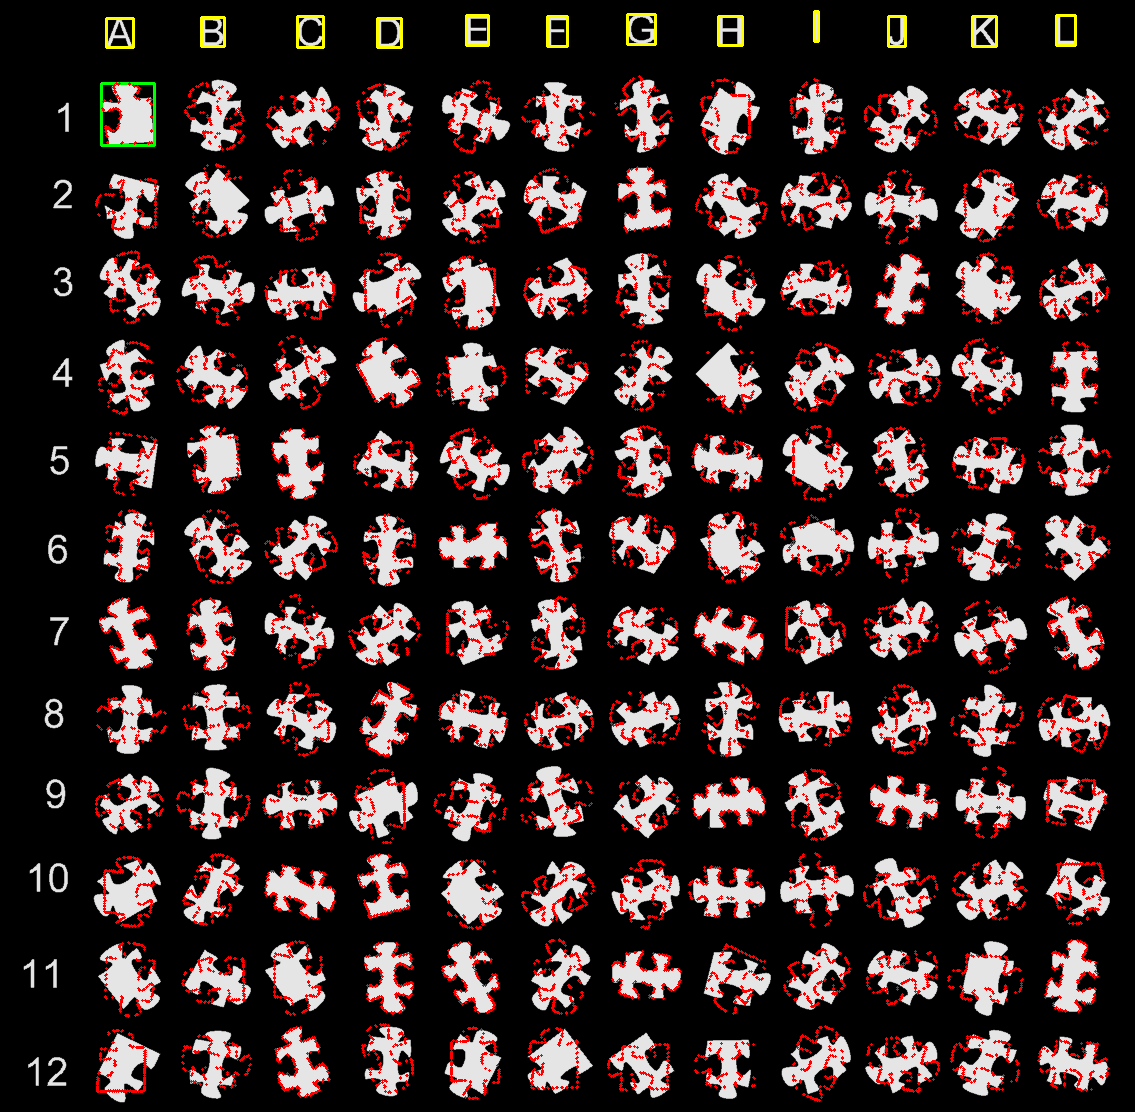

In [155]:

from imutils import contours
import pytesseract
import math
from PIL import Image
from IPython.display import display, clear_output

yellow = (255, 255, 0)
blue = (0, 0, 255)
green = (0, 255, 0)
red = (255, 0, 0)

img = cv2.imread('jigsawsqr.png')
img_bw = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
cnts, _ = cv2.findContours(img_bw, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

letters = []
numbers = []
peices = []

min_peice_area = 1000
numbers_min_y = 100
first_peice = None
first_peice_x_y = []

print (first_peice)

for c in cnts:
    x, y, w, h = cv2.boundingRect(c)
    if cv2.contourArea(c) > min_peice_area:
        if first_peice is None:
            first_peice = c
            first_peice_x_y = [x, y]
        if first_peice_x_y[0] + first_peice_x_y[1] > x + y:
            first_peice = c
            first_peice_x_y = [x, y]
        peices.append(c)
        # cv2.rectangle(img, (x, y), (x + w, y + h), blue, 2)
    else:
        if y > numbers_min_y:
            numbers.append(c)
        else:
            letters.append(c)
            cv2.rectangle(img, (x, y), (x + w, y + h), yellow, 2)

peices = contours.sort_contours(peices, method="left-to-right")[0]
numbers = list(contours.sort_contours(numbers, method="top-to-bottom")[0])
letters = contours.sort_contours(letters, method="left-to-right")[0]

x, y, w, h = cv2.boundingRect(first_peice)
cv2.rectangle(img, (x, y), (x + w, y + h), green, 2)

# join double digit numbers
for i in range(9, len(numbers)-1):
    x1, y1, w1, h1 = cv2.boundingRect(numbers[i])
    x2, y2, w2, h2 = cv2.boundingRect(numbers[i+1])
    if abs(y1-y2) < 5:
        x = min(x1, x2)

        if (y1 > y2):
            h = y1 - y2 + h1
        else:
            h = y2 - y1 + h2
        y = min(y1, y2)
        if (x1 < x2):
            w = x2 + w2 - x1
        else:
            w = x1 + w1 - x2
        
        outer_contour = np.array([[x,y],[x,y+h],[x+w,y],[x+w,y+h]], dtype=np.int32)
        numbers[i+1] = outer_contour
        numbers[i] = None


# remove None values
numbers = [x for x in numbers if x is not None]

mid_numbers = {}

for i in range(0, len(numbers), 1):
    x, y, w, h = cv2.boundingRect(numbers[i])
    mid_numbers[i+1] = [x + w/2, y + h/2]

mid_letters = {}
for i in range(0, len(letters), 1):
    x, y, w, h = cv2.boundingRect(letters[i])
    # number of letters after A
    ltr = chr(65 + i)
    mid_letters[str(ltr)] = [x + w/2, y + h/2]

peice_map = []

for p in peices:
    x, y, w, h = cv2.boundingRect(p)
    n = 0
    l = 'Z'
    for mid_number in mid_numbers.keys():
        x, y, w, h = cv2.boundingRect(p)
        mid_x = mid_numbers[mid_number][0]
        mid_y = mid_numbers[mid_number][1]
        if mid_y > y and mid_y < (y + h):
            n = mid_number
            break
    for mid_letter in mid_letters.keys():
        mid_x = mid_letters[mid_letter][0]
        mid_y = mid_letters[mid_letter][1]
        if mid_x > x and mid_x < x + w:
            l = mid_letter
            break
    peice_map.append([[n,l], p])

def get_angle(peice_map):
    for p, cnt in peice_map:
        x, y, w, h = cv2.boundingRect(cnt)
        key = str(p[0]) + str(p[1])

        epsilon = 0.01*cv2.arcLength(cnt,True)
        approx = cv2.approxPolyDP(cnt,epsilon,True)

        longest = 0
        print_longest = 0
        longest_angle = 0
        for angle in range(0, 360, 1):
            rcnt = rotate_contour(cnt, angle)
            
            dist = 0
            prior_x_pnt = rcnt[0][0]
            prior_y_pnt = rcnt[0][0]
            for i in range(0, len(rcnt)-1):
                j = i + 1
                c1 = rcnt[i][0]
                c2 = rcnt[j][0]

                if prior_x_pnt[0] != c1[0]:
                    prior_x_pnt = c1
                if prior_y_pnt[1] != c1[1]:
                    prior_y_pnt = c1
                
                if c1[0] == c2[0]:
                    dist = abs(prior_x_pnt[1] - c2[1])
                #if c1[1] == c2[1]:
                #    dist =+ abs(prior_y_pnt[0] - c2[0])
                
                if dist > longest:
                    longest = dist
                    longest_angle = angle

        cnt = rotate_contour(cnt, longest_angle)
        cv2.drawContours(img, cnt, -1, red, 2)
        
        
get_angle(peice_map)
    
    
#rotate_contour(cnt, 90), -1, red, 2)
#cv2.putText(img, key, (x, y), cv2.FONT_HERSHEY_SIMPLEX, 1, red, 2)

display(Image.fromarray(img))